In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.graphics.tsaplots import plot_acf
import datetime
from datetime import timedelta
import ipywidgets as widgets
from IPython.display import display

In [57]:
df_combined = pd.read_csv('data/2022-2024_Stats.csv')
df_productivity = pd.read_csv('data/Case_Closure_(Oct22-Jan24)_cleaned.csv')

df_combined

,Date,Open Balances,Closed,New Cases
0,2022-01-01,1963,0,468
1,2022-01-02,2431,0,503
2,2022-01-03,2934,857,1212
3,2022-01-04,3146,727,1039
4,2022-01-05,3368,949,826
...,...,...,...,...
810,2024-03-21,2521,429,428
811,2024-03-22,2499,432,406
812,2024-03-23,2473,11,211
813,2024-03-24,2673,0,214


# Let users choose between Weekly or Monthly

In [3]:
# Define button options and their corresponding parameters
button_options = {
    "Weekly": {"train_days": df_combined[-60:], "num_steps": 7, "p": 7, "d": 1, "q": 2,
               "start_date": pd.Timestamp('2024-03-25'), "td_days": 6, "manpower_days": df_productivity[-60:]},
    "Monthly": {"train_days": df_combined[-100:], "num_steps": 30, "p": 7, "d": 1, "q": 1,
               "start_date": pd.Timestamp('2024-03-25'), "td_days": 29, "manpower_days": df_productivity[-100:]}
}

# Define a function to handle button clicks
def on_button_clicked(b):
    global clicked_button, train_days, num_steps, p, d, q, start_date, end_date, manpower_days
    clicked_button = b.description
    print("Button clicked:", clicked_button)

    # Update parameters based on the clicked button
    parameters = button_options.get(clicked_button)
    if parameters:
        train_days = parameters["train_days"]
        num_steps = parameters["num_steps"]
        p, d, q = parameters["p"], parameters["d"], parameters["q"]
        start_date = parameters["start_date"].date()
        td_days = parameters["td_days"]
        end_date = start_date + timedelta(days=td_days)
        manpower_days = parameters["manpower_days"]
        print(len(train_days), num_steps, p, d, q, start_date, end_date, td_days, len(manpower_days))

# Create buttons
buttons = [widgets.Button(description=option) for option in button_options]

# Assign callbacks to buttons
for button in buttons:
    button.on_click(on_button_clicked)

# Display buttons
display(*buttons)

Button(description='Weekly', style=ButtonStyle())

Button(description='Monthly', style=ButtonStyle())

Button clicked: Weekly
60 7 7 1 2 2024-03-25 2024-03-31 6 60


# New Cases: Dynamic Updating of ARIMA

Currently only works if you update for one day

In [ ]:
# only putting this here in case i need to clear input
df_combined = pd.read_csv('data/2022-2024_Stats.csv')
df_combined

In [9]:
# input updated numbers for today

open_balance_input = input("Enter today's Open Balance: ")
close_balance_input = input("Enter today's Close Balance: ")
new_balance_input = input("Enter today's New Balance: ")

original_data = []

# this code causes us to only be able to input 1 day of real values.
# need to find a way to make this more dynamic but for now its workable
train_days = df_combined[-60:]

if open_balance_input.strip() and close_balance_input.strip() and new_balance_input.strip():
    try:
        open_balance = float(open_balance_input)
        close_balance = float(close_balance_input)
        new_balance = float(new_balance_input)
    except ValueError:
        print("Error: Please enter valid numbers for balances.")
    else:
        original_data.append(df_combined.iloc[-1])
        train_days = train_days.drop(df_combined.index[-1])
        new_data = {'Date': start_date,
                    'Open Balances': open_balance,
                    'Closed': close_balance,
                    'New Cases': new_balance
                    }
        train_days = train_days.append(new_data, ignore_index=True)
        print("Values successfully added to DataFrame.")
        print(train_days[-7:])
        print(original_data)

Enter today's Open Balance: 1234
Enter today's Close Balance: 4321
Enter today's New Balance: 111
Values successfully added to DataFrame.
          Date  Open Balances  Closed  New Cases
53  2024-03-19         2786.0   465.0      490.0
54  2024-03-20         2737.0   410.0      390.0
55  2024-03-21         2521.0   429.0      428.0
56  2024-03-22         2499.0   432.0      406.0
57  2024-03-23         2473.0    11.0      211.0
58  2024-03-24         2673.0     0.0      214.0
59  2024-03-25         1234.0  4321.0      111.0
[Date             2024-03-25
Open Balances          2737
Closed                  466
New Cases               445
Name: 814, dtype: object]


/var/folders/9d/9y37blc53yz64mgqtz66xrrw0000gp/T/ipykernel_13474/2567049843.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_days = train_days.append(new_data, ignore_index=True)


In [25]:
def arima_dynamic_forecast(train_days, num_steps, p, d, q, var_to_pred):
    # Extract the 'Open Balances' column
    combined_train_data = train_days[var_to_pred]

    # Initialize history with combined training data
    history = [x for x in combined_train_data]

    predictions = list()

    # Iterate over the number of time steps to make predictions for 2024
    for i in range(num_steps):
        # Fit ARIMA model with seasonal differencing
        model = ARIMA(history, order=(p, d, q))
        model_fit = model.fit()

        # Forecast the next value
        yhat = model_fit.forecast()[0]
        # Append the forecasted value to predictions
        predictions.append(yhat)

        # Update the history with the forecasted value
        history.append(yhat)

    # Now predictions_2024 contains the predicted values for 2024
    print(predictions)
    return predictions


In [26]:
new_cases_pred = arima_dynamic_forecast(train_days, num_steps, p, d, q, var_to_pred='New Cases')

/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[234.20105572291612, 231.70625232146165, 264.5019520312953, 288.3589393901955, 190.83798746867816, 158.65045710372752, 134.36263712928036]


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
def analyse_dynamic_pred(df_combined, predictions, start_date, end_date, var_to_pred):
    # Create time index
    time_index_2024 = pd.date_range(start=start_date, end=end_date, freq='D')

    # Plotting
    plt.figure(figsize=(10, 6))
    
    original_values = [row[var_to_pred] for row in original_data]
    
    stop_pt = len(original_values)

    # if full arima prediction
    if stop_pt == 0:
        plt.plot(time_index_2024, dynamic_predictions, label='Predictions 2024', color='red')
    
    else:
        plt.bar(time_index_2024[:stop_pt], original_values, label='Correct 2024', color='blue')
        # Plot predicted values
        plt.plot(time_index_2024[stop_pt:], dynamic_predictions[stop_pt:], label='Predictions 2024', color='red')
        plt.title('ARIMA Forecast on ' + var_to_pred)
        plt.xlabel('Date')
        plt.ylabel(var_to_pred)
        plt.legend()
        plt.grid(True)
        plt.show()

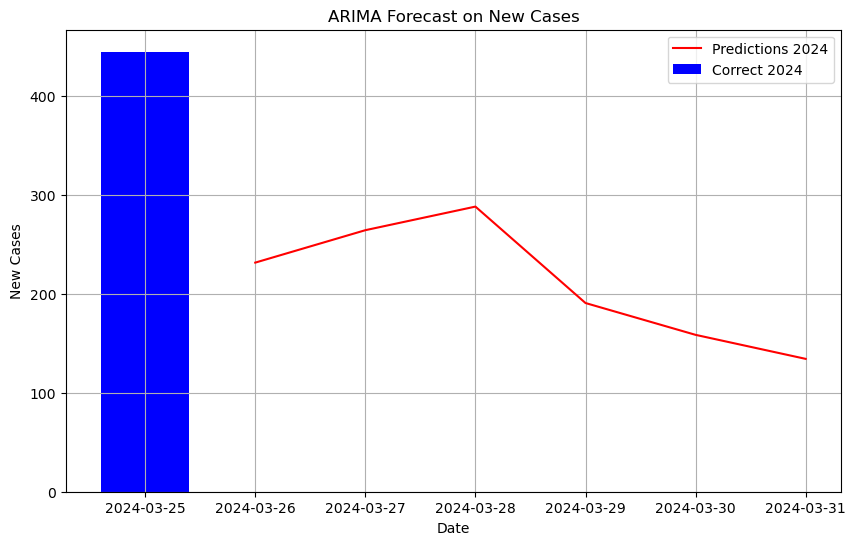

In [17]:
analyse_dynamic_pred(df_combined, dynamic_predictions, start_date, end_date, var_to_pred='New Cases')

# Closed Cases: Dynamic Updating of Simulation

PSA: This one cannot update after the initial prediction because we don't have input for average case closure rate.

In [18]:
def prod_forecast(manpower_days, num_steps, p, d, q):
    
    # predict csa
    csa_train_data = manpower_days['Avg Case Closed Per CSA']

    # Initialize history with combined training data
    csa_history = [x for x in csa_train_data]

    csa = list()

    # Iterate over the number of time steps to make predictions for 2024
    for i in range(num_steps):
        # Fit ARIMA model with seasonal differencing
        model = ARIMA(csa_history, order=(p, d, q))
        model_fit = model.fit()

        # Forecast the next value
        yhat = model_fit.forecast()[0]
        # Append the forecasted value to predictions
        csa.append(yhat)

        # Update the history with the forecasted value
        csa_history.append(yhat)
        
    # predict cse
    cse_train_data = manpower_days['Avg Case Closed Per CSE']

    # Initialize history with combined training data
    cse_history = [x for x in cse_train_data]

    cse = list()

    # Iterate over the number of time steps to make predictions for 2024
    for i in range(num_steps):
        # Fit ARIMA model with seasonal differencing
        model = ARIMA(cse_history, order=(p, d, q))
        model_fit = model.fit()

        # Forecast the next value
        yhat = model_fit.forecast()[0]
        # Append the forecasted value to predictions
        cse.append(yhat)

        # Update the history with the forecasted value
        cse_history.append(yhat)
        
    # predict temps
    temps_train_data = manpower_days['Avg Case Closed per Temp']

    # Initialize history with combined training data
    temp_history = [x for x in temps_train_data]

    temp = list()

    # Iterate over the number of time steps to make predictions for 2024
    for i in range(num_steps):
        # Fit ARIMA model with seasonal differencing
        model = ARIMA(temp_history, order=(p, d, q))
        model_fit = model.fit()

        # Forecast the next value
        yhat = model_fit.forecast()[0]
        # Append the forecasted value to predictions
        temp.append(yhat)

        # Update the history with the forecasted value
        temp_history.append(yhat)
    
    return csa, cse, temp


In [19]:
csa, cse, temp = prod_forecast(manpower_days, num_steps, p, d, q)

print('csa \n', csa, 'cse \n', cse, 'temp \n', temp)

/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaco

csa 
 [23.191622446454485, 18.386931787227297, 1.104543616968595, 1.4984205450938404, 21.246856505594018, 20.501407444027333, 21.395252543172163] cse 
 [28.93841769232565, 25.033656450715704, 2.1299975378125104, 7.356438860077173, 28.038476204758712, 26.596259573322545, 23.249425521645094] temp 
 [14.83276654760262, 9.237631814040888, -1.0119048729825142, 2.8286012845095696, 11.33477356802106, 7.23138034610553, 7.82232975965161]


In [58]:
# input updated numbers for today

csa_input = input("Enter CSA Manpower: ")
cse_input = input("Enter CSE Manpower: ")
temps_input = input("Enter Temp Manpower: ")

try:
    csa_input = float(csa_input)
    cse_input = float(cse_input)
    temps_input = float(temps_input)
except ValueError:
    print("Error: Please enter valid numbers.")
else:
    # Initialize the result array
    cases_closed = []

    # Perform element-wise multiplication and summation
    for csa_val, cse_val, temp_val in zip(csa, cse, temp):
        cases_closed.append(csa_input * csa_val + cse_input * cse_val + temps_input * temp_val)

    print(cases_closed)

Enter CSA Manpower: 10
Enter CSE Manpower: 8
Enter Temp Manpower: 4
[522.7546321935606, 421.0890967341621, 24.037796980255976, 85.15012146959407, 482.1154689660941, 446.7096724112758, 431.2372486434888]


In [65]:
def analyse_pred(cases_closed, start_date, end_date, var_to_sim):
    # Create time index
    time_index_2024 = pd.date_range(start=start_date, end=end_date, freq='D')

    # Plotting
    plt.figure(figsize=(10, 6))

    #plt.plot(time_index_2024, open_balances_values, label='Correct 2024', color='blue')

    # Plot predicted values for 2024
    plt.plot(time_index_2024, cases_closed, label='Simulated '+var_to_sim, color='red')
    plt.title(var_to_sim+' Simulation')
    plt.xlabel('Date')
    plt.ylabel(var_to_sim)
    plt.legend()
    plt.grid(True)
    plt.show()

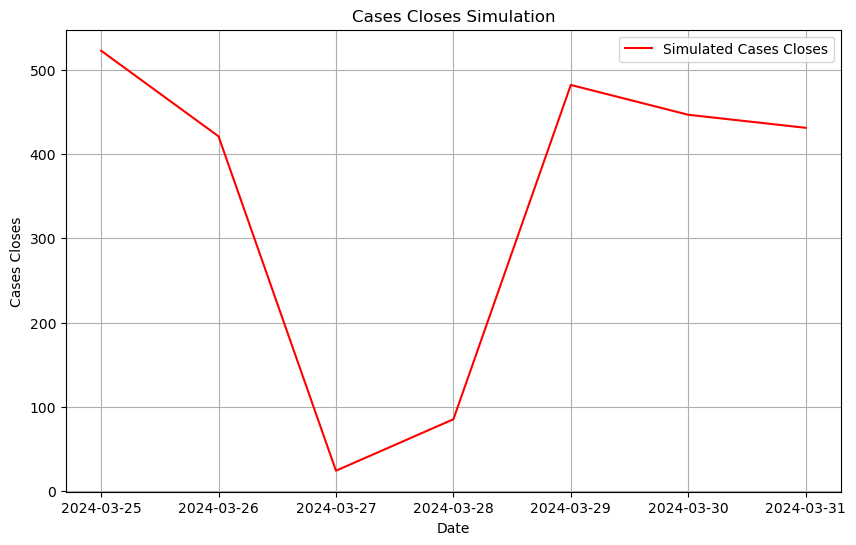

In [66]:
analyse_pred(cases_closed, start_date, end_date, var_to_sim='Cases Closes')

# Open Balance: Dynamic Updating of Simulation

In [52]:
# call the same prev function to predict open balance
open_bal_predictions = arima_dynamic_forecast(train_days, num_steps, p, d, q, var_to_pred='Open Balances')
print(open_bal_predictions)

/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/st

[1022.1963781166592, 418.2442869911347, 708.968586977616, 857.5450689639321, 1324.396736792088, 736.6432190245204, 488.58687006771515]
[1022.1963781166592, 418.2442869911347, 708.968586977616, 857.5450689639321, 1324.396736792088, 736.6432190245204, 488.58687006771515]


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [59]:
day_0_pred=[]

In [61]:
day_0_pred = open_bal_predictions[0]

sim_open = []

sim_open.append(day_0_pred)
print(sim_open)

for i in range(num_steps - 1):
    print(sim_open[i], '+', new_cases_pred[i], '-', cases_closed[i])
    sim_open.append(sim_open[i] + new_cases_pred[i] - cases_closed[i])
    
print(sim_open)

[1022.1963781166592]
1022.1963781166592 + 234.20105572291612 - 522.7546321935606
733.6428016460147 + 231.70625232146165 - 421.0890967341621
544.2599572333143 + 264.5019520312953 - 24.037796980255976
784.7241122843536 + 288.3589393901955 - 85.15012146959407
987.932930204955 + 190.83798746867816 - 482.1154689660941
696.6554487075391 + 158.65045710372752 - 446.7096724112758
[1022.1963781166592, 733.6428016460147, 544.2599572333143, 784.7241122843536, 987.932930204955, 696.6554487075391, 408.5962333999908]


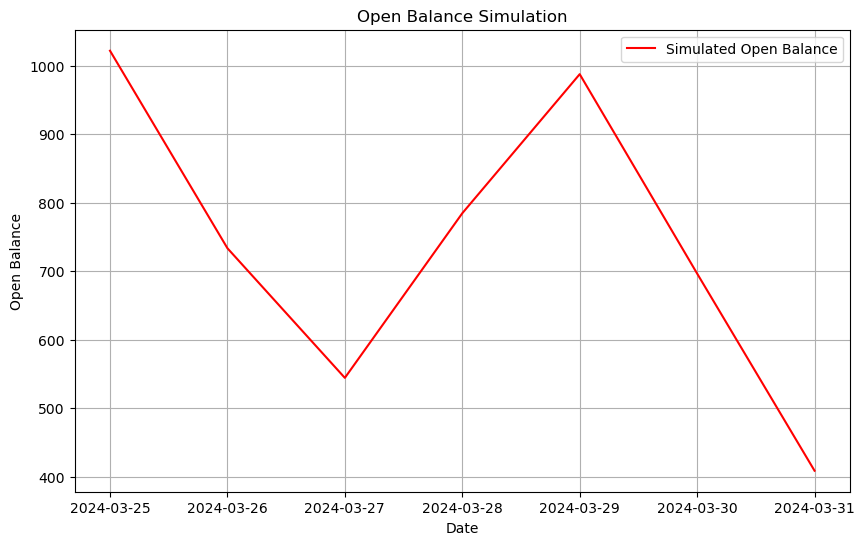

In [68]:
analyse_pred(sim_open, start_date, end_date, var_to_sim='Open Balance')

# Left to do
- Make all numbers whole numbers
- If simulation simulates negative numbers, turn it to 0 instead
- try to make it dynamic so that they can input real numbers for more days than just day 1
- check once more if everything can run smoothly